## Artificial Intelligence (BSc) SA 2024-2025

- Prof. Luca Gambardella
- Fatima Ezzeddine ([`fatima.ezzeddine@usi.ch`](mailto:fatima.ezzeddine@usi.ch))<br>

---

## Third Lab

What we are going to do today:
- Introduce two optimizers for local search methods
- Use the optimizer with the methods defined before
- Implement Iterated Local Search

This cell below is simply importing some useful stuff for later

In [1]:
import glob
import numpy as np
from matplotlib import pyplot as plt
from time import time as t
from utils import compute_length, ProblemInstance, SolverTSP

## Optimizers
### 2opt
As we saw last time, we have 12 problems and two have an optimal solution

## Solution

In [8]:
import numpy as np


def swap2opt(tsp_sequence, i, j):
    n = len(tsp_sequence)
    new_tsp_sequence = np.copy(tsp_sequence)
    # flipping the part between i and j+1
    new_tsp_sequence[i : j + 1 - n] = np.flip(tsp_sequence[i : j + 1 - n], axis=0)
    return new_tsp_sequence


def gain(i, j, tsp_sequence, matrix_dist):
    n = matrix_dist.shape[0]
    old_link_len = (
        matrix_dist[tsp_sequence[i], tsp_sequence[i - 1]]
        + matrix_dist[tsp_sequence[j], tsp_sequence[j + 1 - n]]
    )

    changed_links_len = (
        matrix_dist[tsp_sequence[j], tsp_sequence[i - 1]]
        + matrix_dist[tsp_sequence[i], tsp_sequence[j + 1 - n]]
    )

    return +old_link_len - changed_links_len


def step2opt(solution, matrix_dist, distance):
    seq_length = len(solution)
    tsp_sequence = np.array(solution)

    for i in range(seq_length):
        # (i+ 1) because we do not want i=j,
        # also if we put j before i, and we have a symetric case,
        # we do not have to put j less than i we have the same swaps,
        # so now the cases are divided by 2
        for j in range(i + 1, seq_length):
            # TODO
            if gain(i, j, tsp_sequence, matrix_dist) > 0:
                # update new distance
                new_distance = distance - gain(i, j, tsp_sequence, matrix_dist)
                # swap the tour
                tsp_sequence = swap2opt(tsp_sequence, i, j)
                # return new tour, and new instance
                return tsp_sequence, new_distance, 1
    # END TODO
    return tsp_sequence, distance, 1


# while loop, calling step2opt until the new solution is shorter (an improvment)
# when the new solution is smaller than the previous one then you keep going in the while
# if this is not true, we return the solution we found
def loop2opt(solution, instance, max_num_of_uncrosses=10000):
    matrix_dist = instance.dist_matrix
    new_len = compute_length(solution, matrix_dist)
    new_tsp_sequence = np.copy(np.array(solution))
    uncross = 0
    try_again = True
    seq_length = new_len

    while uncross < max_num_of_uncrosses:
        # TODO
        new_tsp_sequence, new_reward, uncr_ = step2opt(
            new_tsp_sequence, matrix_dist, new_len
        )
        new_tsp_sequence = np.roll(
            new_tsp_sequence, np.random.randint(seq_length)
        ).astype(np.int64)
        if new_reward < new_len:
            new_len = new_reward
            try_again = True
            uncross += uncr_
        else:
            if try_again:
                try_again = False
            else:
                return new_tsp_sequence.tolist(), new_len, uncross
    # END TODO
    return new_tsp_sequence.tolist(), new_len, uncross

#### Let's test it


#############################

name: eil76
nPoints: 76
best_sol: 538.0
exist optimal: False


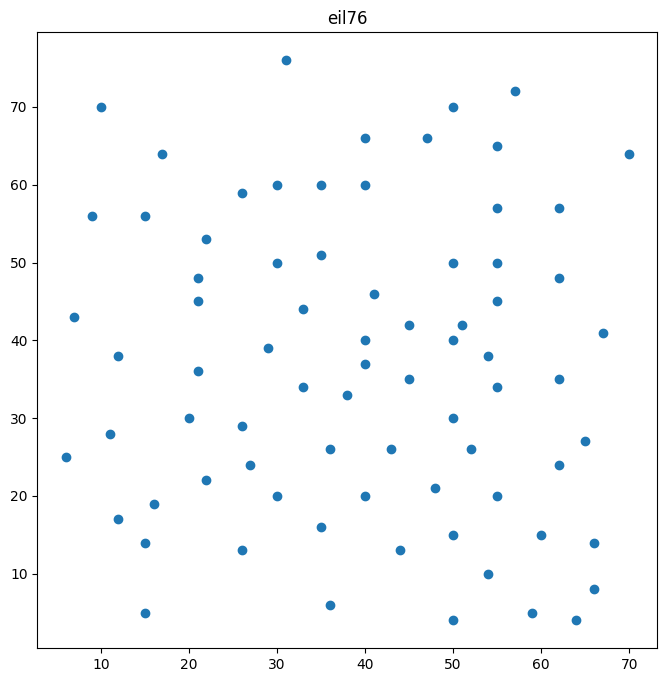

In [9]:
example_problem = "./TSP_problems/eil76.tsp"
p_inst = ProblemInstance(example_problem)
p_inst.print_info()
p_inst.plot_data()

In [10]:
from utils import (
    random_method,
)
available_solvers = {
    "random": random_method,
}

###  solving with random  ####
###  solved  ####


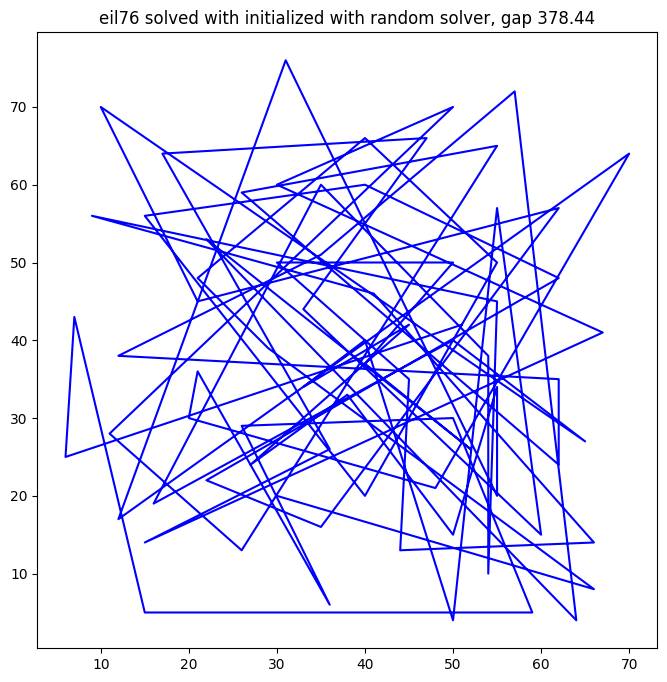

best solution with len 2574.0 
with a total time of 0.00057 seconds
solution found has a 378.44 % gap
0.7845108509063721


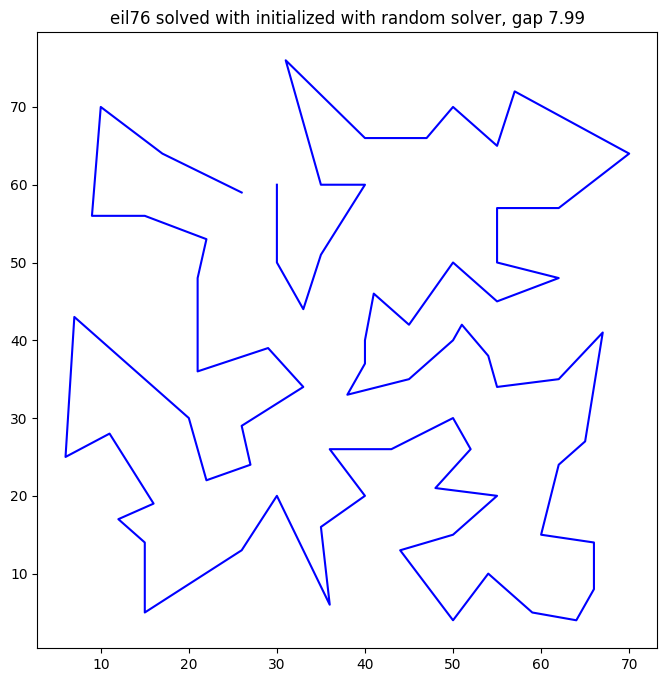

best solution with len 581.0 
with a total time of 0.78451 seconds
 7.99 % gap
with 10000 number of uncrossed edges
581.0 581.0


In [12]:
solver = SolverTSP("random", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")
print(f"solution found has a {solver.gap} % gap")

start = t()
solution, new_length, uncross = loop2opt(solver.solution, p_inst)
# solution, new_length = twoOpt(solver.solution, p_inst)
end = t()
print(end -  start)
solver.method = "random followed by 2 opt"

#assert solver.pass_and_check_if_solution_is_valid(solution), "Solution non valid"
solver.solved = True
solver.solution = solution
solver.plot_solution()
solver._gap()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")
print(f" {solver.gap} % gap")
print(f"with {uncross} number of uncrossed edges")
print(compute_length(solver.solution, p_inst.dist_matrix), solver.found_length)

### 2.5opt

In [16]:
import numpy as np


def step2dot5opt(solution, matrix_dist, distance):
    seq_length = len(solution)
    tsp_sequence = np.array(solution)
    uncrosses = 0
    for i in range(1, seq_length - 1):
        for j in range(i + 2, seq_length - 1):
            # TODO
            # 2opt gain
            normal_gain = gain(i, j, tsp_sequence, matrix_dist)

            # node shift 1 gain
            shift_1_gain = shift_gain1(i, j, tsp_sequence, matrix_dist)

            # node shift 2 gain
            shift_2_gain = shift_gain2(i, j, tsp_sequence, matrix_dist)

            # conditions, check for best option
            best_gain = np.argmax([normal_gain, shift_1_gain, shift_2_gain])
            # return new solution
            if [normal_gain, shift_1_gain, shift_2_gain][best_gain] > 0:
                uncrosses += 1
                if best_gain == 0:
                    # update new distance
                    new_distance = distance - normal_gain
                    # swap the tour
                    tsp_sequence = swap2opt(tsp_sequence, i, j)
                elif best_gain == 1:
                    # update new distance
                    new_distance = distance - shift_1_gain
                    # shift the tour
                    tsp_sequence = shift1(tsp_sequence, i, j)
                else:
                    # update new distance
                    new_distance = distance - shift_2_gain
                    # shift the tour
                    tsp_sequence = shift2(tsp_sequence, i, j)
                # return new tour, and new instance
                return tsp_sequence, new_distance, uncrosses
            # END TODO
    return tsp_sequence, distance, uncrosses


def shift1(tsp_sequence, i, j):
    n = len(tsp_sequence)
    new_tsp_sequence = np.concatenate(
        [
            tsp_sequence[:i],
            tsp_sequence[i + 1 - n : j + 1 - n],
            [tsp_sequence[i]],
            tsp_sequence[j + 1 - n :],
        ]
    )
    return new_tsp_sequence


def shift_gain1(i, j, tsp_sequence, matrix_dist):
    n = matrix_dist.shape[0]
    old_link_len = (
        matrix_dist[tsp_sequence[i], tsp_sequence[i - 1]]
        + matrix_dist[tsp_sequence[i], tsp_sequence[i + 1 - n]]
        + matrix_dist[tsp_sequence[j], tsp_sequence[j + 1 - n]]
    )
    changed_links_len = (
        matrix_dist[tsp_sequence[i - 1], tsp_sequence[i + 1 - n]]
        + matrix_dist[tsp_sequence[i], tsp_sequence[j]]
        + matrix_dist[tsp_sequence[i], tsp_sequence[j + 1 - n]]
    )
    return +old_link_len - changed_links_len


def shift2(tsp_sequence, i, j):
    n = len(tsp_sequence)
    new_tsp_sequence = np.concatenate(
        [
            tsp_sequence[:i],
            [tsp_sequence[j]],
            tsp_sequence[i:j],
            tsp_sequence[j + 1 - n :],
        ]
    )
    return new_tsp_sequence


def shift_gain2(i, j, tsp_sequence, matrix_dist):
    n = matrix_dist.shape[0]
    old_link_len = (
        matrix_dist[tsp_sequence[i], tsp_sequence[i - 1]]
        + matrix_dist[tsp_sequence[j], tsp_sequence[j - 1]]
        + matrix_dist[tsp_sequence[j], tsp_sequence[j + 1 - n]]
    )
    changed_links_len = (
        matrix_dist[tsp_sequence[j], tsp_sequence[i - 1]]
        + matrix_dist[tsp_sequence[i], tsp_sequence[j]]
        + matrix_dist[tsp_sequence[j - 1], tsp_sequence[j + 1 - n]]
    )
    return +old_link_len - changed_links_len


def loop2dot5opt(solution, instance):
    matrix_dist = instance.dist_matrix
    actual_len = compute_length(solution, matrix_dist)
    new_tsp_sequence = np.copy(np.array(solution))
    uncross = 0
    new_len = actual_len
    try_again = True
    while True:
        # TODO
        new_tsp_sequence, new_len, uncr_ = step2dot5opt(
            new_tsp_sequence, matrix_dist, actual_len
        )
        uncross += uncr_
        # print(new_len, actual_len)
        if new_len < actual_len:
            actual_len = new_len
            try_again = True
        else:
            if try_again:
                try_again = False
            else:
                return new_tsp_sequence.tolist(), new_len, uncross

In [21]:
def shift1(tsp_sequence, i, j):
  n = len(tsp_sequence)
  new_tsp_sequence = np.concatenate([tsp_sequence[:i], 
                                     tsp_sequence[i + 1 -n: j + 1 -n], 
                                     [tsp_sequence[i]], 
                                     tsp_sequence[j + 1 - n:]])
  return new_tsp_sequence


def shift2(tsp_sequence, i, j):
  n = len(tsp_sequence)
  new_tsp_sequence = np.concatenate([tsp_sequence[:i], 
                                     [tsp_sequence[j]], 
                                     tsp_sequence[i: j], 
                                     tsp_sequence[j + 1 - n:]])
  return new_tsp_sequence


t = ['x1', 'x2', 'x3', 'x4', 'y1', 'y2', 'y3']
i = 1
j = 3
shift1(t, i, j)
# n = len(t)
# t[:i], t[i + 1 -n: j + 1 -n], [t[i]], t[j + 1 - n:]

array(['x1', 'x3', 'x4', 'x2', 'y1', 'y2', 'y3'], dtype='<U2')

###  solving with random  ####
###  solved  ####


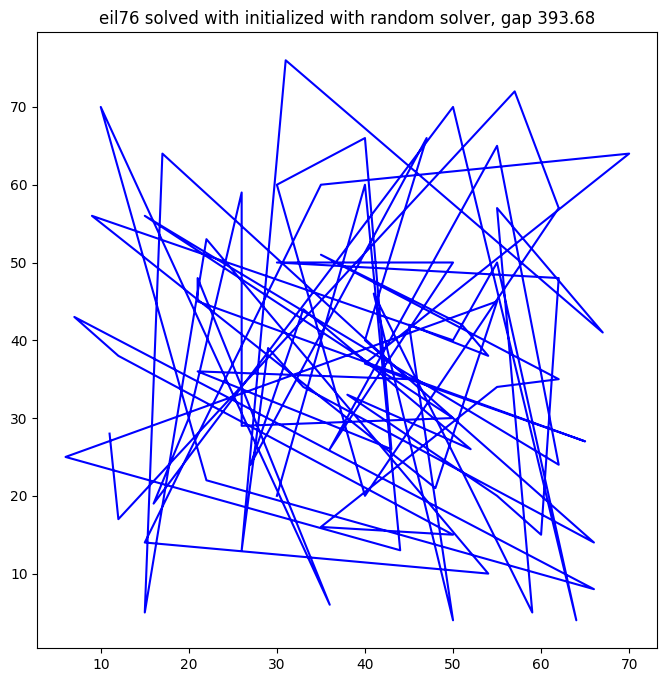

best solution with len 2656.0 
with a total time of 0.00112 seconds
solution found has a 393.68 % gap
0.9348077774047852


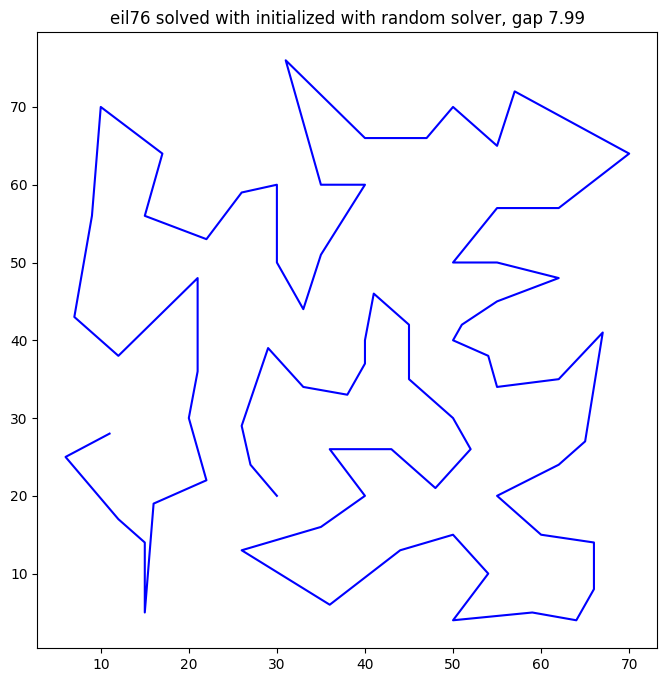

 7.99 % gap
with 265 number of uncrossed edges


In [25]:
from time import time as t

solver = SolverTSP("random", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")
print(f"solution found has a {solver.gap} % gap")

start = t()
solution, new_length, uncross = loop2dot5opt(solver.solution, p_inst)
end = t()
print(end -  start)
solver.method = "random folowed by 2.5 opt"

#assert solver.pass_and_check_if_solution_is_valid(solution), "Solution non valid"
solver.solved = True
solver.solution = solution
solver.plot_solution()
solver._gap()
print(f" {solver.gap} % gap")
print(f"with {uncross} number of uncrossed edges")

### Let's analyse the performances of the optimizers and the algorithms discussed until now


###  solving with random  ####
###  solved  ####


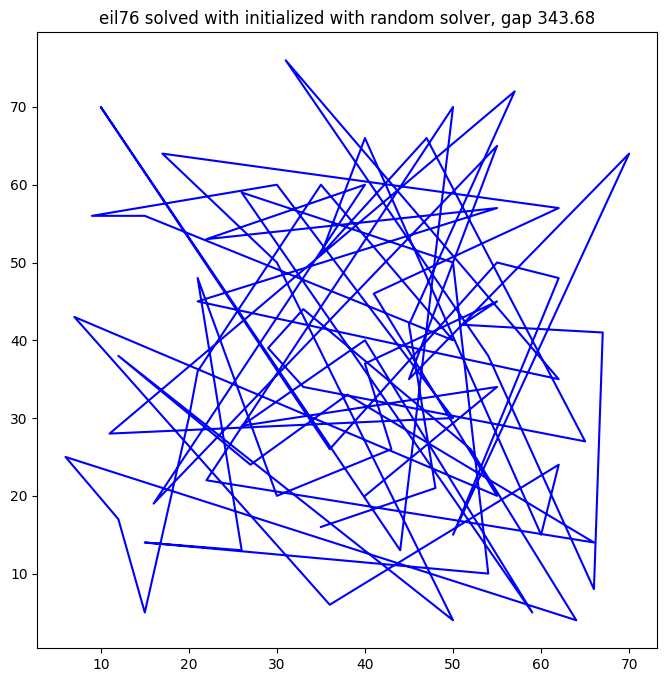

best solution with len 2387.0 
with a total time of 0.00117 seconds
solution found has a 343.68 % gap
0.8211710453033447


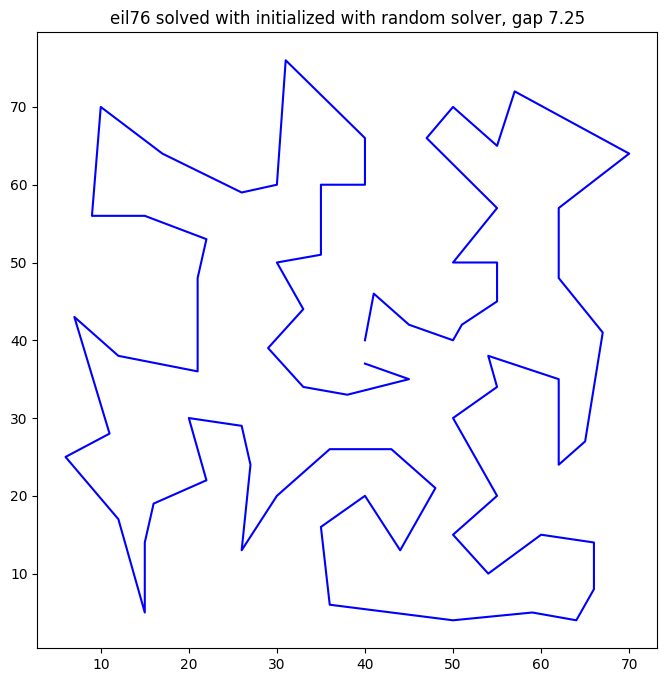

 7.25 % gap
with 10000 number of uncrossed edges
0.9123568534851074


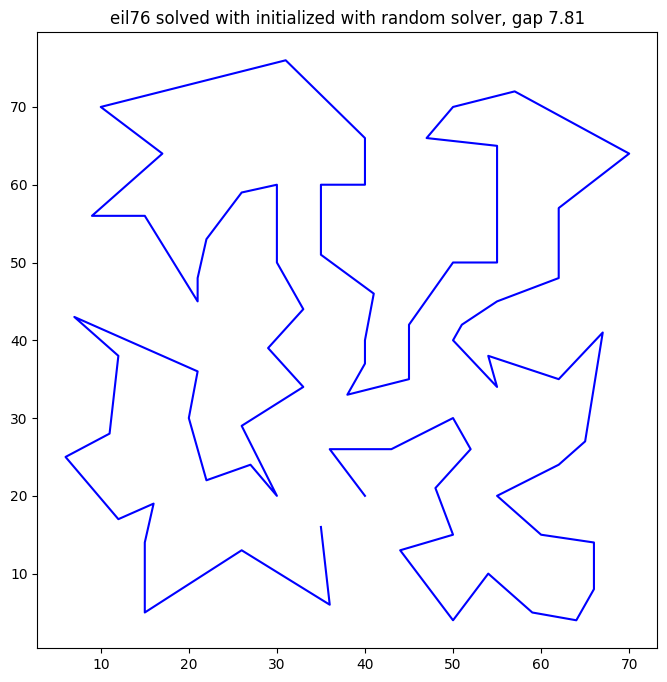

 7.81 % gap
with 212 number of uncrossed edges


In [27]:
solver = SolverTSP("random", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")
print(f"solution found has a {solver.gap} % gap")

old_solution=solver.solution


start = t()
solution, new_length, uncross = loop2opt(old_solution, p_inst)
end = t()
print(end -  start)
solver.method = "random followed by 2 opt"

#assert solver.pass_and_check_if_solution_is_valid(solution), "Solution non valid"
solver.solved = True
solver.solution = solution
solver.plot_solution()
solver._gap()
print(f" {solver.gap} % gap")
print(f"with {uncross} number of uncrossed edges")

start = t()
solution, new_length, uncross = loop2dot5opt(old_solution, p_inst)
end = t()
print(end -  start)
solver.method = "random followed by 2.5 opt"

#assert solver.pass_and_check_if_solution_is_valid(solution), "Solution non valid"
solver.solved = True
solver.solution = solution
solver.plot_solution()
solver._gap()
print(f" {solver.gap} % gap")
print(f"with {uncross} number of uncrossed edges")

# Iterated Local Search

In [28]:
class DoubleBridge:
  
  @staticmethod
  def difference_cost(solution, a, b, c, d, matrix):
    n = matrix.shape[0]
    to_remove = matrix[solution[a-1], solution[a]] + matrix[solution[b-1], solution[b]] + matrix[solution[c-1], solution[c]] + matrix[solution[d-1], solution[d]]
    to_add = matrix[solution[a], solution[c-1]] + matrix[solution[b], solution[d-1]] + matrix[solution[c], solution[a-1]] + matrix[solution[d], solution[b-1]]
    return to_add - to_remove


  @staticmethod
  def perturbate_solution(solution, actual_cost, matrix):
    # generate 4 random indices
    a, b, c, d = np.sort(np.random.choice(matrix.shape[0], size=4, replace=False))
    # get new solution of double bridge
    B = solution[a:b]
    C = solution[b:c]
    D = solution[c:d]
    A = np.concatenate((solution[d:], solution[:a]))
    new_solution = np.concatenate((A,D,C,B))
    # double bridge gain computation
    new_length = actual_cost + DoubleBridge.difference_cost(solution, a, b, c, d, matrix)
    return new_solution, new_length

In [30]:
# same code seen in cells tutorials
# in this case its 2opt, but for ILS it can be any local search algorithm
def local_search(solution, new_len, instance):
    matrix_dist = instance.dist_matrix
    new_tsp_sequence = np.copy(np.array(solution))
    uncross = 0
    seq_length = len(solution)
    try_again = True
    while uncross < 100:
      new_tsp_sequence = np.roll(new_tsp_sequence, np.random.randint(seq_length)).astype(np.int64)
      new_tsp_sequence, new_reward, uncr_ = step2opt(new_tsp_sequence, matrix_dist, new_len)
      uncross += uncr_
      if new_reward < new_len:
        new_len = new_reward
        try_again = True
      else:
        if try_again:
          try_again = False
        else:
          return new_tsp_sequence, new_len

    return new_tsp_sequence.tolist(), new_len

In [33]:
def ils(solution, instance, constant_temperature=0.95, iterations_for_each_temp=100):
    # initial setup
    # initialize the temperature T = tmax
    temperature = instance.best_sol / np.sqrt(instance.nPoints)

    # save current and initialiye best solution variables
    current_sol = np.array(solution)
    current_len = compute_length(solution, instance.dist_matrix)
    best_sol = np.array(solution)
    best_len = current_len

    # main loop
    while temperature > 0.001:
        for it in range(iterations_for_each_temp):
            # TODO
            # perturbation with Double Bridge
            perturbed_sol, perturbed_cost = DoubleBridge.perturbate_solution(
                current_sol, current_len, instance.dist_matrix
            )
            # local search
            next_sol, new_cost = local_search(perturbed_sol, perturbed_cost, instance)
            # END TODO

            # acceptance criterions same as SA
            if new_cost - current_len < 0:
                # print('updated sol')
                current_sol = next_sol
                current_len = new_cost
                if current_len < best_len:
                    # print("update best")
                    best_sol = current_sol
                    best_len = current_len
                    # print(best_len)
                # print()
            else:
                r = np.random.uniform(0, 1)
                if r < np.exp(-(new_cost - current_len) / temperature):
                    current_sol = next_sol
                    current_len = new_cost
        # decrease temprateure
        temperature *= constant_temperature
    return best_sol

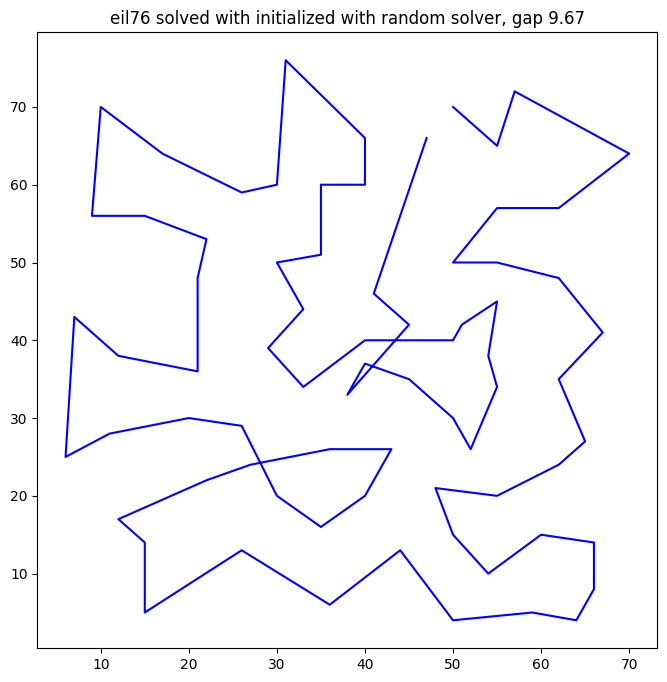

best solution with len 590.0 
 with a total time of 152.9942 seconds
solution found has a 9.67 % gap


In [34]:
start = t()
solution_local = ils(solution, p_inst)
end = t()
solver.method = "local search folowed by ILS"

#assert solver.pass_and_check_if_solution_is_valid(solution), "Solution non valid"
solver.solved = True
solver.solution = solution_local
solver.plot_solution()
solver._gap()
print(f"best solution with len {solver.found_length} \n with a total time of {np.round(end - start, 5)} seconds")
print(f"solution found has a {solver.gap} % gap")